In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

import importlib
import tools.pltw as pltw

def reload_modules():
    importlib.reload(pltw)


In [2]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [69]:
df = pd.read_csv(
    '/home/pbiel/repos/mrp/gavra/results_a1_2_20250810_235705/process_reassignments_sol2.csv',
    converters={
        'ProcessResourceRequirements': ast.literal_eval,
    }
)
df['ProcessTotalReq'] = df['ProcessResourceRequirements'].apply(sum)

print(f"Solution contains {len(df)} reassignments.")
df.head()

# Only use first 25% of the data for analysis
#df = df.iloc[:len(df) // 4]
print(f"Reduced to {len(df)} reassignments for analysis.")

df.head()


Solution contains 1945 reassignments.
Reduced to 1945 reassignments for analysis.


,MoveNum,ProcessID,SourceMachine,DestMachine,OriginalMachine,Service,MoveCost,ProcessResourceRequirements,Improvement,Timestamp,...,SourceMachineCapacities,DestMachineCapacities,SourceMachineTransientUsage,DestMachineTransientUsage,SourceMachineProcessCount,DestMachineProcessCount,LoadCost,BalanceCost,SolutionCost,ProcessTotalReq
0,1,1,6,23,60,11,1,"[425647, 435001, 123315, 27354]",0.0,1754866672000,...,"[2156793,1907324,1315410,702673]","[2614227,3192815,2727080,2379658]","[1348286,1287464,1189639,582945]","[3003062,3297073,2478994,2198652]",10,18,7858752000,0,7858862910,1011317
1,2,2,52,17,76,12,1,"[1185, 726, 3098, 397110]",0.0,1754866672000,...,"[1192036,1097748,2579939,2008544]","[1223539,1978966,2904411,1548044]","[1087066,953953,2516222,1217508]","[1018230,1637783,2892992,1749018]",15,8,7881013800,0,7881122710,402119
2,3,6,46,72,5,15,1,"[89538, 165663, 282151, 179349]",0.0,1754866672000,...,"[1540978,1177326,1463613,3555778]","[688053,901955,3178273,1215803]","[1307716,1005655,1148129,2615006]","[760986,970087,3127823,1166367]",10,14,7923564400,0,7923674310,716701
3,4,17,72,71,72,26,1,"[48849, 88742, 190642, 3417]",0.0,1754866672000,...,"[688053,901955,3178273,1215803]","[3415134,5358117,10941650,1717340]","[712137,881345,3127823,1162950]","[3258101,4283319,10981270,1351238]",13,13,7923564400,0,7923674320,331650
4,5,21,16,88,59,30,1,"[48873, 44496, 45753, 658915]",0.0,1754866672000,...,"[3091782,1905901,2702704,2694959]","[645116,453407,269836,1698862]","[2639146,1772776,2645519,1444816]","[541434,441177,276655,2092224]",16,7,7989336000,0,7989445920,798037


In [64]:
print(f"Total reassignments: {len(df)}")
print(f"Unique processes moved: {df['ProcessID'].nunique()}")
print(f"Unique source machines: {df['SourceMachine'].nunique()}")
print(f"Unique destination machines: {df['DestMachine'].nunique()}")
print(f"Unique solutions: {df['SolutionId'].nunique()}")
print(f"Final solution cost: {df['SolutionCost'].iloc[-1]}")
print(f"Cost improvement: {df['SolutionCost'].iloc[0] - df['SolutionCost'].iloc[-1]}")


Total reassignments: 2331
Unique processes moved: 508
Unique source machines: 83
Unique destination machines: 83
Unique solutions: 10
Final solution cost: 7787937580
Cost improvement: 48150680


Analysis into:
- Process distribution by size
- Process reassignments distribution by size
- Process reassignments over solution
- Solution Cost across reassignments
- Solution Cost Improvement across reassignments

In [65]:
def analyze_process_reassignments(df):
    # Count how many times each process was moved
    process_moves = df['ProcessID'].value_counts()

    print(f"Most frequently moved processes:")
    print(process_moves.head(10))
    
    print(f"\nMovement distribution:")
    print(f"Processes moved once: {sum(process_moves == 1)}")
    print(f"Processes moved 2-5 times: {sum((process_moves >= 2) & (process_moves <= 5))}")
    print(f"Processes moved >5 times: {sum(process_moves > 5)}")
    print(f"Max moves for single process: {process_moves.max()}")
    
    return process_moves

process_reassignments = analyze_process_reassignments(df)


Most frequently moved processes:
ProcessID
61     10
142    10
211    10
889    10
851    10
791    10
891    10
137    10
789    10
733    10
Name: count, dtype: int64

Movement distribution:
Processes moved once: 87
Processes moved 2-5 times: 219
Processes moved >5 times: 202
Max moves for single process: 10


In [ ]:
reload_modules()


In [ ]:
# Get unique process sizes by process ID
unique_process_sizes = df.groupby('ProcessID')['ProcessTotalReq'].first().reset_index()
print(f"Unique process sizes:\n{unique_process_sizes}")

process_size_quantiles = unique_process_sizes['ProcessTotalReq'].quantile([0.25, 0.5, 0.75, 1.0])
print(f"Process size quantiles:\n{process_size_quantiles}")

# Calculate portion of processes under 25% quantile
process_under_25 = unique_process_sizes[unique_process_sizes['ProcessTotalReq'] < process_size_quantiles[0.25]]
print(f"Processes under 25% quantile ({process_size_quantiles[0.25]}): {len(process_under_25)} out of {len(unique_process_sizes)}")
print(f"Size {process_size_quantiles[0.25]} is {process_size_quantiles[0.25] / unique_process_sizes['ProcessTotalReq'].max() * 100:.2f}% of the largest process size ({unique_process_sizes['ProcessTotalReq'].max()})")


Unique process sizes:
     ProcessID  ProcessTotalReq
0            1          1011317
1            2           402119
2            6           716701
3            7           268213
4           11            40382
..         ...              ...
503        992           825637
504        993           295211
505        994             4736
506        995           824655
507        999            77852

[508 rows x 2 columns]
Process size quantiles:
0.25      78941.25
0.50     263770.00
0.75     647001.25
1.00    3457107.00
Name: ProcessTotalReq, dtype: float64
Processes under 25% quantile (78941.25): 127 out of 508
Size 78941.25 is 2.28% of the largest process size (3457107)


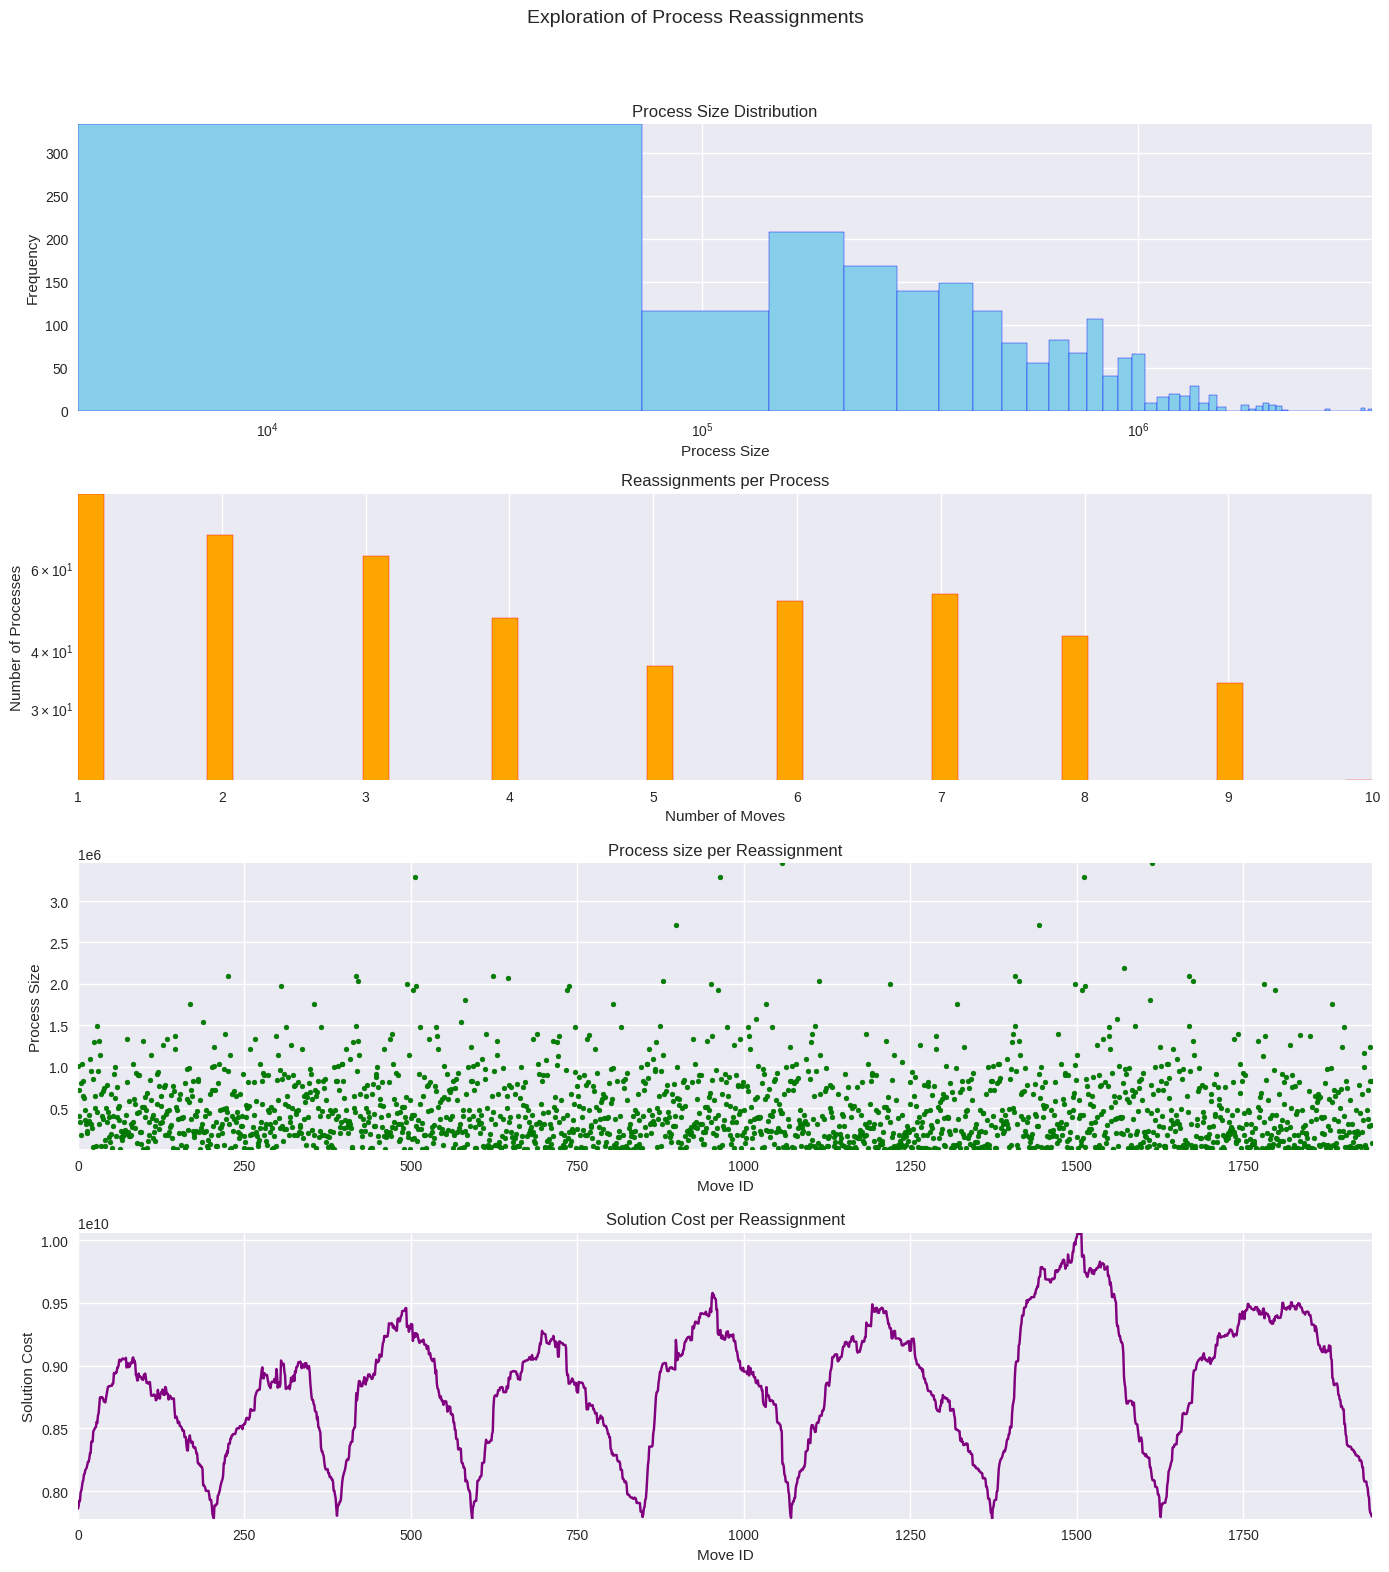

In [71]:
pltw.fig(
    ttl="Exploration of Process Reassignments",
    plots=[
        pltw.plot(ttl="Process Size Distribution",
                  ylbl="Frequency",
                  xlbl="Process Size",
                  x=50,
                  y=df['ProcessTotalReq'],
                  kwargs={"color": 'skyblue', "edgecolor": 'blue', "ptype": 'hist', "xscale": 'log'}),

        pltw.plot(ttl="Reassignments per Process",
                  ylbl="Number of Processes",
                  xlbl="Number of Moves",
                  y=process_reassignments.values,
                  x=50,
                  kwargs={"color": 'orange', "edgecolor": 'red', "ptype": 'hist', "yscale": 'log'}),

        pltw.plot(ttl="Process size per Reassignment",
                  ylbl="Process Size",
                  xlbl="Move ID",
                  y=df['ProcessTotalReq'],
                  kwargs={"color": 'green', "edgecolor": 'darkgreen', "ptype": 'scatter', "marker": '.'}),

        pltw.plot(ttl="Solution Cost per Reassignment",
                  ylbl="Solution Cost",
                  xlbl="Move ID",
                  y=df['SolutionCost'],
                  kwargs={"color": 'purple'}),
    ],
)


- Solution state changes

Solution change points: [0, 205, 390, 593, 849] ... [849, 1072, 1374, 1627, 1945]


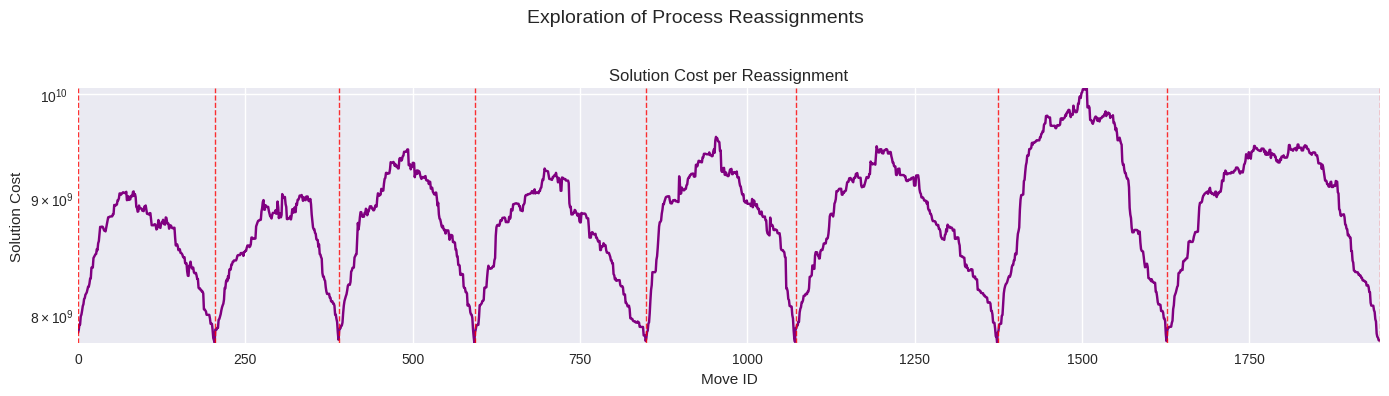

In [ ]:
sol_mask = df['SolutionId'].ne(df['SolutionId'].shift()) # Boolean mask for solution ID changes
sol_change_points = sol_mask.index[sol_mask].tolist()  # Get indices where solution ID changes
sol_change_points = sol_change_points + [len(df)]  # Include start and end of DataFrame
print(f"Solution change points: {sol_change_points[:5]} ... {sol_change_points[-5:]}")

pltw.fig(
    ttl="Exploration of Process Reassignments",
    plots=[
        pltw.plot(ttl="Solution Cost per Reassignment",
                  ylbl="Solution Cost",
                  xlbl="Move ID",
                  y=df['SolutionCost'],
                  vlines=sol_change_points,
                  kwargs={"color": 'purple', "yscale": 'log'}),
    ]
)
